## Filter data around semidiurnal frequency and store subsample (time) in diags directory

In [1]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8583002.datarmor0/parcels-502090/libparcels_random_2b1052c3-b802-48cf-b98e-63134d496457.so


In [16]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=12, cores=12) #processes=7, cores=7
w = cluster.scale(jobs=8
                 )
client = Client(cluster)

In [3]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [17]:
ds = xr.open_zarr(ut.work_data_dir+'rechunked/SSV_rot.zarr')
grd = ut.load_grd()[['XC', 'YC', 'Depth']]#.persist()

In [18]:
isel=dict(face=6)
V = ['SSV_rot']#'zonal_velocity','meridional_velocity'
path = '/home1/datawork/zcaspar/mit4320/filtered_E/'
dsel = 100

#Sel = [dict(i=slice(0,None), j=slice(0,500)),dict(i=slice(0,None), j=slice(1201,2400)),
#       dict(i=slice(0,None), j=slice(2401,3600)),dict(i=slice(0,None), j=slice(3601,None))]
#dsp = ds.isel(**isel).persist()

In [6]:
j_0,j_1 = 0,dsel
Sel = []
while j_1<=ds.j.values.max():
    Sel.append(dict(i=slice(0,None), j=slice(j_0,j_1)))
    j_0=j_1+1
    j_1+=dsel
Sel.append(dict(i=slice(0,None), j=slice(j_0,None)))
Sel

[{'i': slice(0, None, None), 'j': slice(0, 100, None)},
 {'i': slice(0, None, None), 'j': slice(101, 200, None)},
 {'i': slice(0, None, None), 'j': slice(201, 300, None)},
 {'i': slice(0, None, None), 'j': slice(301, 400, None)},
 {'i': slice(0, None, None), 'j': slice(401, 500, None)},
 {'i': slice(0, None, None), 'j': slice(501, 600, None)},
 {'i': slice(0, None, None), 'j': slice(601, 700, None)},
 {'i': slice(0, None, None), 'j': slice(701, 800, None)},
 {'i': slice(0, None, None), 'j': slice(801, 900, None)},
 {'i': slice(0, None, None), 'j': slice(901, 1000, None)},
 {'i': slice(0, None, None), 'j': slice(1001, 1100, None)},
 {'i': slice(0, None, None), 'j': slice(1101, 1200, None)},
 {'i': slice(0, None, None), 'j': slice(1201, 1300, None)},
 {'i': slice(0, None, None), 'j': slice(1301, 1400, None)},
 {'i': slice(0, None, None), 'j': slice(1401, 1500, None)},
 {'i': slice(0, None, None), 'j': slice(1501, 1600, None)},
 {'i': slice(0, None, None), 'j': slice(1601, 1700, None)},
 

In [6]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#(omega_M2+omega_S2)/2
Tw = 30
dband = 0.2
V = ['SSV_rot']

In [7]:
import dask
def wrap_filter(_ds,dt=dt):
    h = sp.generate_filter(om, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
#    _ds = _ds.chunk(dict(time=16,i=100,j=100))
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True)#.persist()
    #        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
            #ds_hat[v+'_demodulated_real']=ds_hat[v+'_demodulated'].real
            #ds_hat[v+'_demodulated_imag']=ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])
    ds_hat = ds_hat.chunk(dict(time=16,i=4320//4))
    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [19]:
sel = dict(i=slice(0,None),j=slice(0,300))
dsp = ds.isel(**isel)#.sel(**sel)#.persist()
dsp = dsp.chunk({"time": -1,'i':100,'j':70})#.persist()#,'i':100,'j':70

In [20]:
om,Tw,dband,V = omega,Tw,dband,V

In [21]:
import os
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsp, 
                                        wrap_filter,
                                        overwrite=True,
                                        suffix="SSV_filtered_face6.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        j=dsel
                                       )

#_ds = ut.custom_distribute(dsp,wrap_filter,
#                        tmp_dir=ut.root_data_dir+'filtered_itide/test_filter',
#                        append=True,
#                       j=200,
#                       )

44it [1:06:42, 90.96s/it]


In [38]:
ds_out

,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray


In [7]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [8]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=12, cores=12,walltime='03:00:00') #processes=7, cores=7 ,walltime='03:00:00'
w = cluster.scale(jobs=11
                 )
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.47:33404 Dashboard: http://10.148.0.47:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'

ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSV_filtered_face%s.zarr'%i
                           ) for i in np.arange(0,3)],dim='face')#.persist()
#ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered_%s.zarr'%i
#                           ) for i in np.arange(3,6)],dim='face')
#ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered_%s.zarr'%i
#                           ) for i in ['00','01']],dim='face')
#ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered_01.zarr')
#ds = ut.custom_distribute_concat(xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered_face0.zarr'),
#                                 tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
#                                suffix='SSU_filtered.zarr')
#client.restart()

#dsp = dsp.chunk({"time": -1}).persist() #,"i":10,"j":10

In [10]:
def concat(ds):
    _ds = ds#xr.concat(ds,dim='face')
    _ds = _ds.chunk(dict(time=16,i=4320//4
                        )) #,j=4320//4
    _ds = ut._reset_chunk_encoding(_ds)
    return _ds

In [6]:
ds = ds.persist()

In [21]:
ds

,Array,Chunk
Bytes,4.69 TiB,18.46 MiB
Shape,"(2, 4320, 4320, 8640)","(1, 70, 1080, 16)"
Count,803522 Tasks,267840 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,4.69 TiB,18.46 MiB
Shape,"(2, 4320, 4320, 8640)","(1, 70, 1080, 16)"
Count,803522 Tasks,267840 Chunks
Type,complex128,numpy.ndarray


In [12]:
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds, 
                                        concat,
                                        overwrite=True,
                                        suffix="SSV_filtered_0.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
#                                        face=2
                                        j=200
                                       )

0it [10:09, ?it/s]


KeyboardInterrupt: 

In [ ]:
ds_out

In [13]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [5]:
ds.attrs.update(ds_0.attrs)

In [44]:
ds

<xarray.Dataset>
Dimensions:          (i: 2160, j: 2160, time: 1464)
Coordinates:
    CS               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    lat              (j, i) float64 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    lon              (j, i) float64 dask.array<chunksize=(601, 2160), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(601, 2160), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
Attributes:
    Tw:         30
    bandwidth:  0.4
    dt:         6h
    face:       12
    omega:      1.9661368071336223

In [6]:
ds = ds.chunk({'time':-1,'i':96,'j':144})

In [22]:
print(ds_0.j,ds_1.j)

<xarray.DataArray 'j' (j: 501)>
array([   0,    2,    4, ...,  996,  998, 1000])
Coordinates:
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 986 988 990 992 994 996 998 1000
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC <xarray.DataArray 'j' (j: 500)>
array([1002, 1004, 1006, ..., 1996, 1998, 2000])
Coordinates:
  * j        (j) int64 1002 1004 1006 1008 1010 ... 1992 1994 1996 1998 2000
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC


In [22]:
path

'/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'

In [23]:
path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'
#path = '/home1/datawork/zcaspar/mit4320/filtered_E/'

ut.store_diagnostic('SSU_filtered', ds,directory=path,auto_rechunk=False)

KeyboardInterrupt: 

In [47]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'OK', 'OK', 'OK', 'OK', 'OK', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 't

Client Scheduler: tcp://10.148.0.255:59945 Dashboard: http://10.148.0.255:8787/status,Cluster Workers: 32 Cores: 32 Memory: 511.04 GiB


In [60]:
path = '/home/datawork-lops-osi/equinox/mit4320/filtered_itide/'
#path = '/home1/datawork/zcaspar/mit4320/filtered_E/'

ds = xr.open_zarr(path+'ZC_filtered_itide_face10.zarr').persist()

In [61]:
ds.face

1

In [65]:
grd = ut.load_grd().isel(face=ds.face).persist()

In [66]:
ds = ds.drop_vars(['lon','lat']).persist()
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC

In [67]:
ds.face

<xarray.DataArray 'face' ()>
array(0)
Coordinates:
    face     int64 0
Attributes:
    standard_name:  face_index

In [68]:
dsi = ds.sel(i=slice(2700,2900),j=slice(2900,3100)).isel(time=slice(int(360//2*24/6-5*24/6),int(360//2*24/6+5*24/6
                                                                                               ))).persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


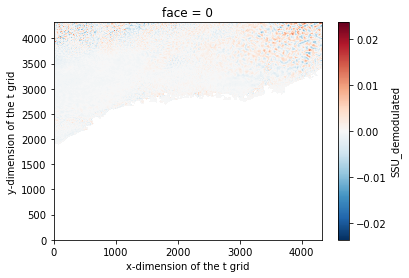

In [72]:
ds.mean('time').SSU_demodulated.real.plot()

In [74]:
ds.j

<xarray.DataArray 'j' (j: 2160)>
array([   0,    2,    4, ..., 4314, 4316, 4318])
Coordinates:
  * j        (j) int64 0 2 4 6 8 10 12 14 ... 4306 4308 4310 4312 4314 4316 4318
    face     int64 0
Attributes:
    axis:           Y
    long_name:      y-dimension of the t grid
    standard_name:  y_grid_index
    swap_dim:       YC

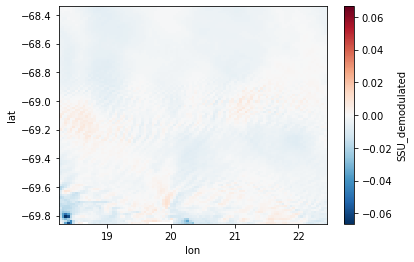

In [46]:
dsi.mean('time').SSU_demodulated.real.plot(x='lon',y='lat')

In [5]:
ds['zonal_velocity_demodulated'] = ds['SSU_demodulated']*ds.CS - ds['SSV_demodulated']*ds.SN
ds['meridional_velocity_demodulated'] =  ds['SSU_demodulated']*ds.SN + ds['SSV_demodulated']*ds.CS

In [52]:
#

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [70]:
ds = ds.assign_coords({'lon':ds.lon,'lat':ds.lat})
ds = ds.persist()

In [54]:
ds

<xarray.Dataset>
Dimensions:          (face: 13, i: 2160, j: 2160, time: 1464)
Coordinates:
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
    CS               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    Depth            (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    SN               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    XC               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    YC               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
    rA               (j, i) float32 dask.array<chunksize=(144, 96), meta=np.ndarray>
  * time             (time) datetime64[ns] 2011-11-15 ... 2012-11-14T18:00:00
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    lon              (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    lat              (face, j, i) float64 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
Data variables:
    SSU_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSU_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_demodulated  (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
    SSV_hat          (j, i, time) complex128 dask.array<chunksize=(144, 96, 1464), meta=np.ndarray>
Attributes:
    Tw:         30
    bandwidth:  0.4
    dt:         6h
    face:       0
    omega:      1.9661368071336223

In [24]:
ds.isel(time=slice(0,10)).SSU_demodulated.real.mean('time').plot(vmax=0.2,x='lon',y='lat')

KeyboardInterrupt: 

In [ ]:
cluster.close()